# Calculating embeddings

In order to cluster the texts we have to obtain vector representations of the `description` and `show_description` columns.

## Load the data and define schema

In [1]:
from pyspark.sql.types import (
    StructType, StructField, 
    StringType, IntegerType, 
    DateType, LongType, 
    BooleanType
)

from utils import load_csv_to_df, create_optimized_spark_session, create_spark_session

podcast_schema = StructType([
    # Date type features
    StructField("date", DateType(), True),
    StructField("release_date", DateType(), True),
    
    # Numerical features
    StructField("rank", IntegerType(), True),
    StructField("duration_ms", LongType(), True),
    StructField("show_total_episodes", IntegerType(), True),
    
    # Binary (Boolean) features
    StructField("explicit", BooleanType(), True),
    StructField("is_externally_hosted", BooleanType(), True),
    StructField("is_playable", BooleanType(), True),
    StructField("show_is_externally_hosted", BooleanType(), True),
    StructField("show_explicit", BooleanType(), True),
    
    # Nominal (Categorical String) features
    StructField("region", StringType(), True),
    StructField("episodeUri", StringType(), True),
    StructField("showUri", StringType(), True),
    StructField("episodeName", StringType(), True),
    StructField("description", StringType(), True),
    StructField("show_name", StringType(), True),
    StructField("show_description", StringType(), True),
    StructField("show_ublisher", StringType(), True),
    StructField("language", StringType(), True),
    StructField("languages", StringType(), True),
    StructField("show_copyrights", StringType(), True),
    StructField("show_href", StringType(), True),
    StructField("show_html_description", StringType(), True),
    StructField("show_languages", StringType(), True),
    StructField("show_media_type", StringType(), True),
    StructField("show_type", StringType(), True),
    StructField("show_uri", StringType(), True),
    
    # Ordinal features
    StructField("chartRankMove", StringType(), True),
    StructField("release_date_precision", StringType(), True)
])



In [ ]:
spark = create_spark_session()
df = load_csv_to_df(spark, "top_podcasts.csv")

#rename problematic column names
for col in df.columns:
  df = df.withColumnRenamed(col, col.replace('.', '_'))

## Create pipeline for sentence embedding

In [2]:
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

description_documentAssembler = DocumentAssembler() \
            .setInputCol("description") \
            .setOutputCol("document")

show_description_documentAssembler = DocumentAssembler() \
    .setInputCol("show_description") \
    .setOutputCol("document")

# Create sentence detector
sentenceDetector = SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

# Create the embeddings
embeddings = XlmRoBertaSentenceEmbeddings.pretrained("sent_xlm_roberta_base", "xx") \
    .setInputCols("sentence") \
    .setOutputCol("embeddings")


pipeline_description = Pipeline().setStages([
    description_documentAssembler,
    sentenceDetector,
    embeddings
])

pipeline_show_description = Pipeline().setStages([
    show_description_documentAssembler,
    sentenceDetector,
    embeddings
])



sent_xlm_roberta_base download started this may take some time.
Approximate size to download 619.5 MB
[ | ]

24/12/02 23:06:35 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.
24/12/02 23:06:36 WARN S3AbortableInputStream: Not all bytes were read from the S3ObjectInputStream, aborting HTTP connection. This is likely an error and may result in sub-optimal behavior. Request only the bytes you need via a ranged GET or drain the input stream after use.


sent_xlm_roberta_base download started this may take some time.
Approximate size to download 619.5 MB
[ | ]Download done! Loading the resource.
[ | ]

2024-12-02 23:10:26.442557: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-02 23:10:27.374606: W external/org_tensorflow/tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 768006144 exceeds 10% of free system memory.


[OK!]


### Saving the modified dataframe with embeddings into parquet files
The code below executes for many hours (21 hours on 6 core CPU in our case).

In [4]:
from pyspark.sql.functions import col
# First transformation
description_result = pipeline_description.fit(df).transform(df) \
    .drop("document", "sentence") \
    .withColumn('description_embedding', col("embeddings.embeddings")) \
    .drop("embeddings")

# Second transformation
show_description_result = pipeline_show_description.fit(description_result).transform(description_result) \
    .drop("document", "sentence") \
    .withColumn('show_description_embedding', col("embeddings.embeddings")) \
    .drop("embeddings")

show_description_result.write.mode("overwrite").parquet('./embeddingi.parquet')

24/12/02 23:12:34 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


# Calculating average embeddings
In this section we will take calculated embeddings via deep learning model and we will average them aggregating them based on region or by show_name.


In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode, collect_list, concat_ws

# stop any existing session
try:
    spark.stop()
except:
    pass

# create new Spark session
spark = SparkSession.builder \
    .appName("Region_Processing") \
    .master("local[2]") \
    .config("spark.driver.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "2") \
    .config("spark.python.worker.memory", "1g") \
    .config("spark.driver.maxResultSize", "1g") \
    .getOrCreate()

24/12/07 08:24:14 WARN Utils: Your hostname, bitdoh-linux resolves to a loopback address: 127.0.1.1; using 10.80.1.80 instead (on interface enp2s0)
24/12/07 08:24:14 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/07 08:24:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Aggregating by region

We want to calculate average emebeddings that will be representative of whole region, so that we can cluster regions based on similarities between them. Here we process the regions, preparing list of unique regions for further processing. The code below may seem very unopitimized but the more optimized approaches basically took all RAM we had, resulting in crushes so this was the safest way to proceed. 

In [7]:
input_path = "embeddingi.parquet"
output_base = "./avg_embeddingi_by_region"

# get dimension of embeddings from first row
sample_embedding = spark.read.parquet(input_path).select("description_embedding").first()[0][0]
embedding_size = len(sample_embedding)

# create the averaging expression for each position in the embedding
avg_expressions = [f"avg(embedding_array[{i}]) as col_{i}" for i in range(embedding_size)]
array_constructor = [f"col_{i}" for i in range(embedding_size)]

# get unique regions
regions = spark.read.parquet(input_path) \
    .select("region").distinct() \
    .rdd.map(lambda x: x.region).collect()

print(f"Found {len(regions)} regions to process")

Found 22 regions to process


Here we go region by region calculating the individual embeddings for regions.

In [9]:
from pyspark.sql.functions import array, expr
from pyspark.sql.types import ArrayType, FloatType



for region in regions:
    print(f"Processing region: {region}")
    try:
        # Read and filter data for this region
        region_df = spark.read.parquet(input_path) \
            .filter(f"region = '{region}'")
        
        # Process embeddings
        result = region_df.select(
            "region",
            explode("description_embedding").alias("embedding_array")
        ).groupBy("region").agg(
            *[expr(expr_str) for expr_str in avg_expressions]
        ).select(
            "region",
            array(*array_constructor).alias("avg_description_embedding")
        )
        
        # Save result for this region
        result.write.mode("overwrite").parquet(f"{output_base}/region={region}")
        
        # Clear cache
        spark.catalog.clearCache()
        
    except Exception as e:
        print(f"Error processing region {region}: {str(e)}")
        continue

Processing region: es


24/12/05 10:03:55 WARN DAGScheduler: Broadcasting large task binary with size 1315.6 KiB


Processing region: gb


24/12/05 10:04:44 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: us


24/12/05 10:05:26 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: ar


24/12/05 10:06:09 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: au


24/12/05 10:06:54 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: at


24/12/05 10:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: br


24/12/05 10:08:20 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: ie


24/12/05 10:09:00 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: mx


24/12/05 10:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: pl


24/12/05 10:10:18 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: nl


24/12/05 10:11:00 WARN DAGScheduler: Broadcasting large task binary with size 1317.1 KiB


Processing region: ca


24/12/05 10:11:39 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: cl


24/12/05 10:12:18 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: co


24/12/05 10:12:57 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: fr


24/12/05 10:13:37 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: de


24/12/05 10:14:18 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: in


24/12/05 10:14:59 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: id


24/12/05 10:15:39 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: it


24/12/05 10:16:17 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: jp


24/12/05 10:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: nz


24/12/05 10:17:36 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


Processing region: ph


24/12/05 10:18:17 WARN DAGScheduler: Broadcasting large task binary with size 1318.6 KiB


As each region was stored in seperate parquet file, we join them together to allow for future analysis.

In [ ]:
print("Combining results...")
final_df = spark.read.parquet(output_base)
final_df.coalesce(1).write \
    .mode("overwrite") \
    .parquet("avg_embeddingi.parquet")

# Show sample of results
print("\nSample of final results:")
final_df.show(5, truncate=False)

In [11]:
final_df.count()

22

We have 22 embeddings, one for each region. This is what we wanted to achieve.

## Aggregating by show name

This part was created to check if the model is linguistically biased: if the same information encoded in different languages gets vastly different vector representations, but due to the fact that our dataset was huge, the data complexity as well, our hardware could not handle such work. Here we do the similar steps as before, looking for number of individual `show_name` that appeared in our dataset.

In [7]:

input_path = "embeddingi.parquet"
output_base = "./avg_embeddingi_by_show_name.parquet"

# get dimension of embeddings from first row
sample_embedding = spark.read.parquet(input_path).select("description_embedding").first()[0][0]
embedding_size = len(sample_embedding)

# create the averaging expression for each position in the embedding
avg_expressions = [f"avg(embedding_array[{i}]) as col_{i}" for i in range(embedding_size)]
array_constructor = [f"col_{i}" for i in range(embedding_size)]

# get unique regions
show_names = spark.read.parquet(input_path) \
    .select("show_name").distinct() \
    .rdd.map(lambda x: x.show_name).collect()

print(f"Found {len(show_names)} show_names to process")

Found 7943 show_names to process


We have 7943 show_names which is 360 times more than regions. Calculation of each region took at least 5 seconds per region, on that pace, these embeddings would be done calculating in 11 hours. We do not have that much time. 

In [6]:
from pyspark.sql.functions import array, expr
from pyspark.sql.types import ArrayType, FloatType


for show_name in show_names:
    print(f"Processing region: {show_name}")
    try:
        # read and filter data for this show_name
        show_name_df = spark.read.parquet(input_path) \
            .filter(f"show_name = '{show_name}'")
        
        # process embeddings
        result = show_name_df.select(
            "region",
            explode("description_embedding").alias("embedding_array")
        ).groupBy("region").agg(
            *[expr(expr_str) for expr_str in avg_expressions]
        ).select(
            "region",
            array(*array_constructor).alias("avg_description_embedding")
        )
        
        # save result for this region
        result.write.mode("overwrite").parquet(f"{output_base}/show_name={show_name}")
        
        # clear cache
        spark.catalog.clearCache()
        
    except Exception as e:
        print(f"Error processing region {show_name}: {str(e)}")
        continue

Processing region:  del problema amb el Suave Fest. Reaccionem a la revelació sobre Clara Chía i la mare de Piqué."


24/12/07 08:28:20 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/12/07 08:28:31 WARN DAGScheduler: Broadcasting large task binary with size 1315.6 KiB


Processing region: Más de uno


24/12/07 08:29:11 WARN DAGScheduler: Broadcasting large task binary with size 1316.5 KiB


Processing region: Crónica Rosa


24/12/07 08:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1318.1 KiB


Processing region: Carne Cruda Podcast


ERROR:root:KeyboardInterrupt while sending command.               (21 + 2) / 49]
Traceback (most recent call last):
  File "/home/bitdoh/miniconda3/envs/sparknlp/lib/python3.8/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/home/bitdoh/miniconda3/envs/sparknlp/lib/python3.8/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/home/bitdoh/miniconda3/envs/sparknlp/lib/python3.8/socket.py", line 681, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

24/12/07 08:30:24 WARN DAGScheduler: Broadcasting large task binary with size 1318.1 KiB


This code would calculate the embeddings for given shows but this process would take too much time for our needs. Then the following analysis would just need to be repeated with parquet file `avg_embeddingi_by_show_name.parquet` instead of `avg_embeddingi_by_region`.

# Clustering

This part is dedicated towards clustering the embeddings obtained from the previous step.

## Loading the average region embeddings

In [1]:
import pyspark
from utils import create_spark_session
spark = create_spark_session()

df = spark.read.parquet('./avg_embeddingi_by_region')


24/12/07 08:51:18 WARN Utils: Your hostname, bitdoh-linux resolves to a loopback address: 127.0.1.1; using 10.80.1.80 instead (on interface enp2s0)
24/12/07 08:51:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/bitdoh/miniconda3/envs/sparknlp/lib/python3.8/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/bitdoh/.ivy2/cache
The jars for the packages stored in: /home/bitdoh/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-7c4e7c6c-4586-42ff-8fda-cab5a10dcecf;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;5.5.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in centra

Here we create automatic pipeline that:
1. prepares data to the format that can be handled by PySpark clustering transformers (vectorizing embedding and changing it's name to veatures)
2. creates pipeline with StandardScaler, PCA and clustering method of choice with adjustable number of clusters
3. let us keep track of performance of different clustering methods with different number of clusters, with Sillhouette Coefficient
4. plots the best result with scatterplot to vizualize objects, colored by clusters
5. plots the bar plot of clustering methods with respect to achieved Sillhouette Coefficients


Evaluating KMEANS...


KMEANS (k=2), silhouette=0.6009498548398112


KMEANS (k=3), silhouette=0.4700891210157568


KMEANS (k=4), silhouette=0.7665866800608199


KMEANS (k=5), silhouette=0.7334449802128528


KMEANS (k=6), silhouette=0.7843204150798381


KMEANS (k=7), silhouette=0.7704417839886747


KMEANS (k=8), silhouette=0.7435520096211964

Evaluating BISECTING...


bisecting - k=3 produced only one cluster, skipping


bisecting - k=4 produced only one cluster, skipping


bisecting - k=5 produced only one cluster, skipping


bisecting - k=6 produced only one cluster, skipping


bisecting - k=7 produced only one cluster, skipping


bisecting - k=8 produced only one cluster, skipping

Evaluating GMM...


GMM (k=2), silhouette=0.266490545450572


GMM (k=3), silhouette=0.3854865212299286


GMM (k=4), silhouette=0.2717679271997916


GMM (k=5), silhouette=0.06907378806515382


GMM (k=6), silhouette=0.6100003739621589


GMM (k=7), silhouette=0.5750232701478922


GMM (k=8), silhouette=0.5644248459661297

All methods sorted by silhouette score:
KMEANS (k=6): 0.7843
KMEANS (k=7): 0.7704
KMEANS (k=4): 0.7666
KMEANS (k=8): 0.7436
KMEANS (k=5): 0.7334
GMM (k=6): 0.6100
KMEANS (k=2): 0.6009
GMM (k=7): 0.5750
GMM (k=8): 0.5644
KMEANS (k=3): 0.4701
GMM (k=3): 0.3855
GMM (k=4): 0.2718
GMM (k=2): 0.2665
GMM (k=5): 0.0691


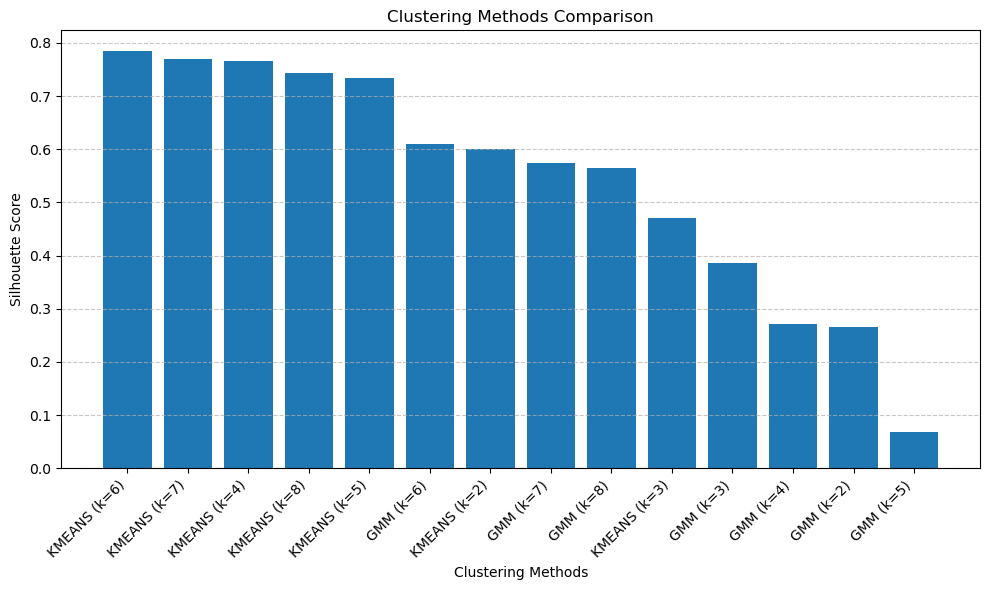


Best method: KMEANS (k=6)
Silhouette Score: 0.7843


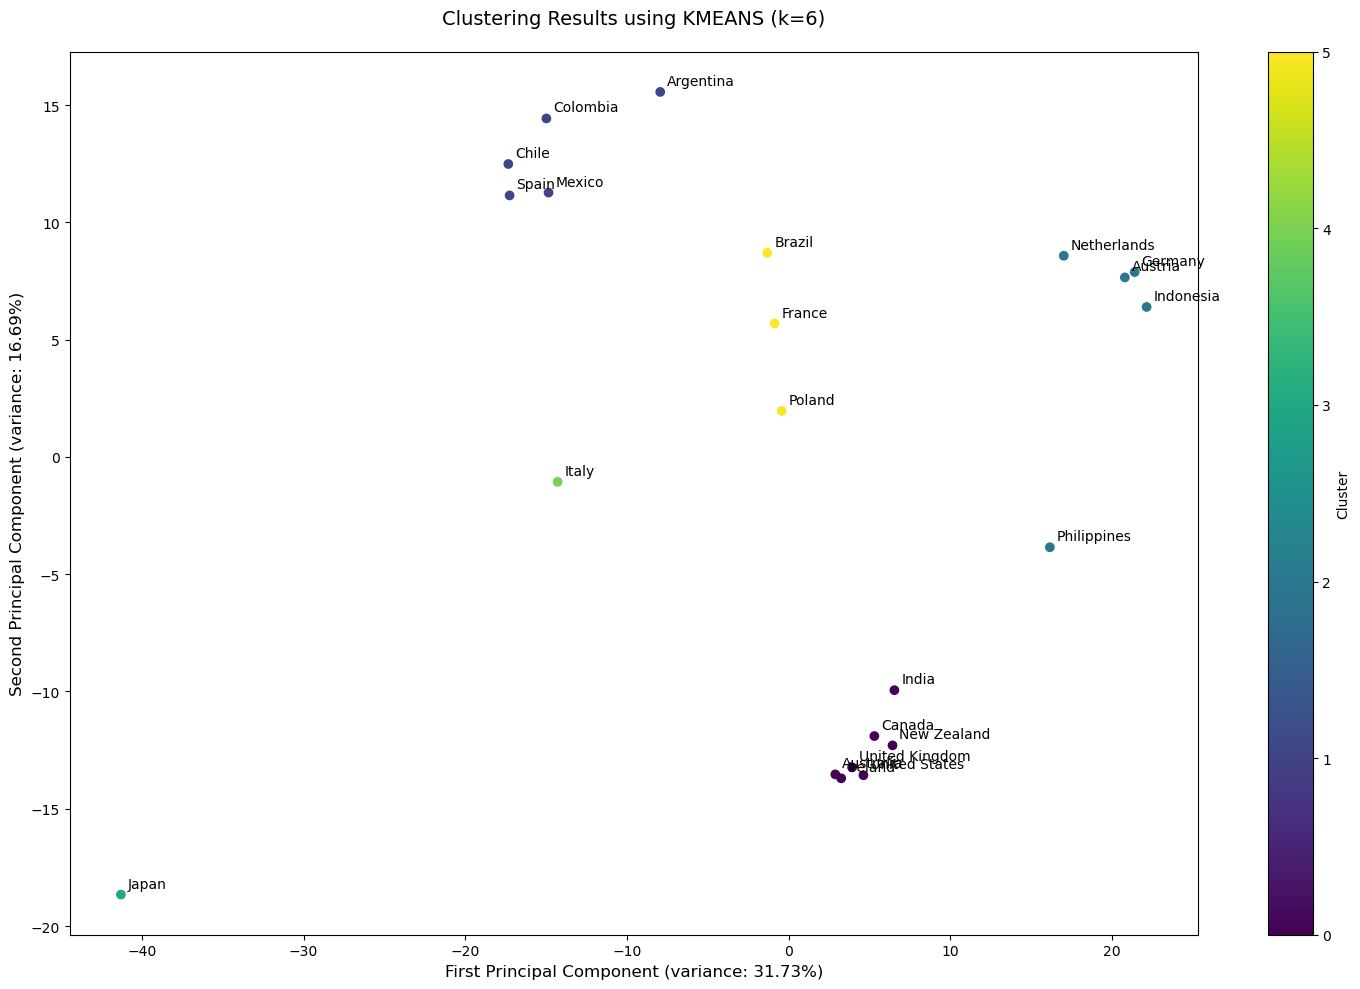

In [2]:
from pyspark.ml.feature import StandardScaler, PCA
from pyspark.ml.clustering import KMeans, BisectingKMeans, GaussianMixture
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(spark_df):
    array_to_vector = udf(lambda arr: Vectors.dense(arr), VectorUDT())
    return spark_df.select(
        "region",
        array_to_vector("avg_description_embedding").alias("features")
    )

def create_pipeline(method='kmeans', k=3, pca_k=2):
    standardizer = StandardScaler(
        inputCol="features",
        outputCol="scaled_features",
        withStd=True,
        withMean=True
    )
    
    pca = PCA(
        k=pca_k,
        inputCol="scaled_features",
        outputCol="pca_features"
    )
    
    if method == 'kmeans':
        clustering = KMeans(
            k=k,
            featuresCol="pca_features",
            predictionCol="cluster",
            seed=42
        )
    elif method == 'bisecting':
        clustering = BisectingKMeans(
            k=k,
            featuresCol="pca_features",
            predictionCol="cluster",
            seed=42,
            minDivisibleClusterSize=2
        )
    else:  # GMM
        clustering = GaussianMixture(
            k=k,
            featuresCol="pca_features",
            predictionCol="cluster",
            seed=42
        )
        
    return Pipeline(stages=[standardizer, pca, clustering])

def evaluate_method(df, method, max_k=8):
    all_results = []  # List to store (method_name, k, silhouette) tuples
    evaluator = ClusteringEvaluator(
        predictionCol="cluster", 
        featuresCol="pca_features", 
        metricName="silhouette"
    )
    
    start_k = 3 if method == 'bisecting' else 2
    
    for k in range(start_k, max_k + 1):
        try:
            pipeline = create_pipeline(method=method, k=k)
            model = pipeline.fit(df)
            transformed_df = model.transform(df)
            
            n_clusters = transformed_df.select("cluster").distinct().count()
            if n_clusters > 1:
                silhouette = evaluator.evaluate(transformed_df)
                # Store method name with k and silhouette score
                method_name = f"{method.upper()} (k={k})"
                all_results.append((method_name, k, silhouette, model))
                print(f"{method_name}, silhouette={silhouette}")
            else:
                print(f"{method} - k={k} produced only one cluster, skipping")
                
        except Exception as e:
            print(f"Error with {method}, k={k}: {str(e)}")
            continue
            
    return all_results

def plot_clusters(df, model, title):
    # Country code to name and flag mapping
    country_mapping = {
        "ar": "Argentina",
        "au": "Australia",
        "at": "Austria",
        "br": "Brazil",
        "ca": "Canada",
        "cl": "Chile",
        "co": "Colombia",
        "fr": "France",
        "de": "Germany",
        "in": "India",
        "id": "Indonesia",
        "ie": "Ireland",
        "it": "Italy",
        "jp": "Japan",
        "mx": "Mexico",
        "nz": "New Zealand",
        "ph": "Philippines",
        "pl": "Poland",
        "es": "Spain",
        "nl": "Netherlands",
        "gb": "United Kingdom",
        "us": "United States"
    }
    
    # Get PCA features and clusters
    result_df = model.transform(df)
    
    # Convert to numpy for plotting
    pca_features = np.array([row.pca_features.toArray() for row in result_df.select("pca_features").collect()])
    clusters = [row.cluster for row in result_df.select("cluster").collect()]
    regions = [row.region for row in result_df.select("region").collect()]
    
    # Create plot
    plt.figure(figsize=(15, 10))  # Increased figure size for better label visibility
    scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='viridis')
    
    # Add region labels with full names and flags
    for i, region in enumerate(regions):
        label = country_mapping.get(region, region)  # Use original code if not in mapping
        plt.annotate(label, 
                    (pca_features[i, 0], pca_features[i, 1]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=10)
    
    plt.title(f'Clustering Results using {title}', fontsize=14, pad=20)
    plt.colorbar(scatter, label='Cluster')
    
    # Add explained variance
    pca_model = model.stages[1]
    var1, var2 = pca_model.explainedVariance
    plt.xlabel(f'First Principal Component (variance: {var1:.2%})', fontsize=12)
    plt.ylabel(f'Second Principal Component (variance: {var2:.2%})', fontsize=12)
    
    plt.tight_layout()
    return plt.gcf()

# Main execution
input_df = spark.read.parquet("avg_embeddingi.parquet")
prepared_df = prepare_data(input_df)

methods = ['kmeans', 'bisecting', 'gmm']
all_results = []

# Collect all results
for method in methods:
    print(f"\nEvaluating {method.upper()}...")
    method_results = evaluate_method(prepared_df, method)
    all_results.extend(method_results)

# Sort results by silhouette score in descending order
sorted_results = sorted(all_results, key=lambda x: x[2], reverse=True)

# Print sorted results
print("\nAll methods sorted by silhouette score:")
for method_name, k, silhouette, _ in sorted_results:
    print(f"{method_name}: {silhouette:.4f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
methods = [r[0] for r in sorted_results]
scores = [r[2] for r in sorted_results]

plt.bar(range(len(methods)), scores)
plt.xticks(range(len(methods)), methods, rotation=45, ha='right')  # Rotated labels for better readability
plt.ylabel('Silhouette Score')
plt.xlabel('Clustering Methods')
plt.title('Clustering Methods Comparison')
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added grid for better readability
plt.tight_layout()  # Adjust layout to prevent label cutoff
plt.show()

# Get best result
best_method_name, best_k, best_score, best_model = sorted_results[0]
print(f"\nBest method: {best_method_name}")
print(f"Silhouette Score: {best_score:.4f}")

# Plot clusters for best model
plot_clusters(prepared_df, best_model, best_method_name)
plt.show()

This result concludes this task. We managed to obtain the sensible clustering for regions based on descriptions of podcast episodes. The question remains if the clustering is based on language or on the semantic content. The clusters that got created are in many cases mono-lingual but for example Indonesia got close with German countries, so it may constitute a counter-example to that allegation.